# Indonesian Spelling Corrector

### Project Overview

This project aims to develop a spelling correction system for Indonesian text using RNN model trained on an Indonesian root word dataset. The dataset includes correct spellings and common misspellings, and preprocessing involves tokenization and conversion to root forms. Training involves fine-tuning RNN to learn the mapping between misspelled and correct words. Evaluation includes metrics like accuracy, precision, recall, and F1 score, with potential improvements such as different architectures or hyperparameters. The system can be deployed for real-time spelling correction, enhancing the accuracy and readability of Indonesian text.

### Import Libraries

In [1]:
# Utilities
import pandas as pd
import numpy as np
from collections import Counter
import re
import random

# Deep Learning
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg" # static plotly

import warnings
warnings.filterwarnings('ignore')

### Dataset Input

In [2]:
# Open the file 'root_word.txt' in read mode
with open('./root_word.txt', 'r') as file:
    # Read all lines from the file and store them in a list
    lines = file.readlines()

# Remove newline characters from each line using list comprehension
lines = [line.strip() for line in lines]

# Print the first 30 lines of the list
print(lines[:30])

# Print the total number of lines in the list
print(len(lines))

['aal', 'aau', 'aba', 'abaabad', 'abadi', 'abadiah', 'abadiat', 'abah', 'abahabai', 'abaimana', 'abaka', 'abaksial', 'abaktinal', 'abakus', 'abalabalone', 'abampere', 'aban', 'abandira', 'abandonemen', 'abang', 'abangan', 'abangga', 'abar', 'abasia', 'abat', 'abate', 'abatisasi', 'abatoar', 'abau', 'abawi']
41409


### EDA

In [3]:
# Calculate the length of each root word
word_lengths = [len(word) for word in lines]

# Calculate the frequency distribution of word lengths
length_counts = {}
for length in word_lengths:
    length_counts[length] = length_counts.get(length, 0) + 1

# Calculate the most common prefixes and suffixes
prefixes = {}
suffixes = {}
for word in lines:
    prefix = word[:2]  # Assuming a prefix is the first two characters
    suffix = word[-2:]  # Assuming a suffix is the last two characters
    prefixes[prefix] = prefixes.get(prefix, 0) + 1
    suffixes[suffix] = suffixes.get(suffix, 0) + 1

# Create DataFrames for word lengths, prefixes and suffixes
word_lengths_df = pd.DataFrame({'Word Length': word_lengths})
prefix_df = pd.DataFrame(list(prefixes.items()), columns=['Prefix', 'Frequency']).sort_values('Frequency', ascending=False).head(10)
suffix_df = pd.DataFrame(list(suffixes.items()), columns=['Suffix', 'Frequency']).sort_values('Frequency', ascending=False).head(10)

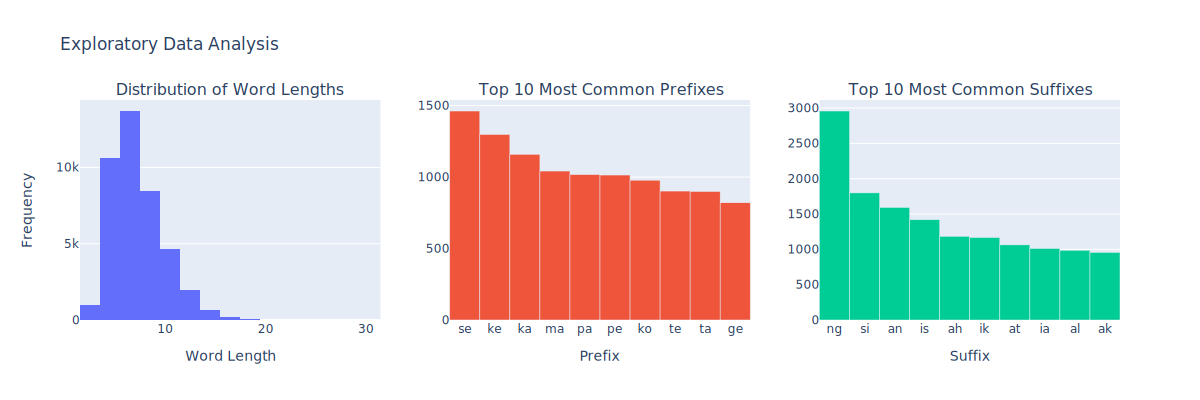

In [4]:
# Create subplots
fig = make_subplots(rows=1, cols=3, subplot_titles=['Distribution of Word Lengths', 'Top 10 Most Common Prefixes', 'Top 10 Most Common Suffixes'])

# Add histograms to the first subplot
fig.add_trace(go.Histogram(x=word_lengths_df['Word Length'], nbinsx=20), row=1, col=1)

# Add bar charts to the second subplot
fig.add_trace(go.Bar(x=prefix_df['Prefix'], y=prefix_df['Frequency']), row=1, col=2)
fig.add_trace(go.Bar(x=suffix_df['Suffix'], y=suffix_df['Frequency']), row=1, col=3)

# Update layout
fig.update_layout(showlegend=False, height=400, width=1200, title_text='Exploratory Data Analysis')
fig.update_xaxes(title_text='Word Length', row=1, col=1)
fig.update_xaxes(title_text='Prefix', row=1, col=2)
fig.update_xaxes(title_text='Suffix', row=1, col=3)
fig.update_yaxes(title_text='Frequency', row=1, col=1)

# Show plot
fig.show()

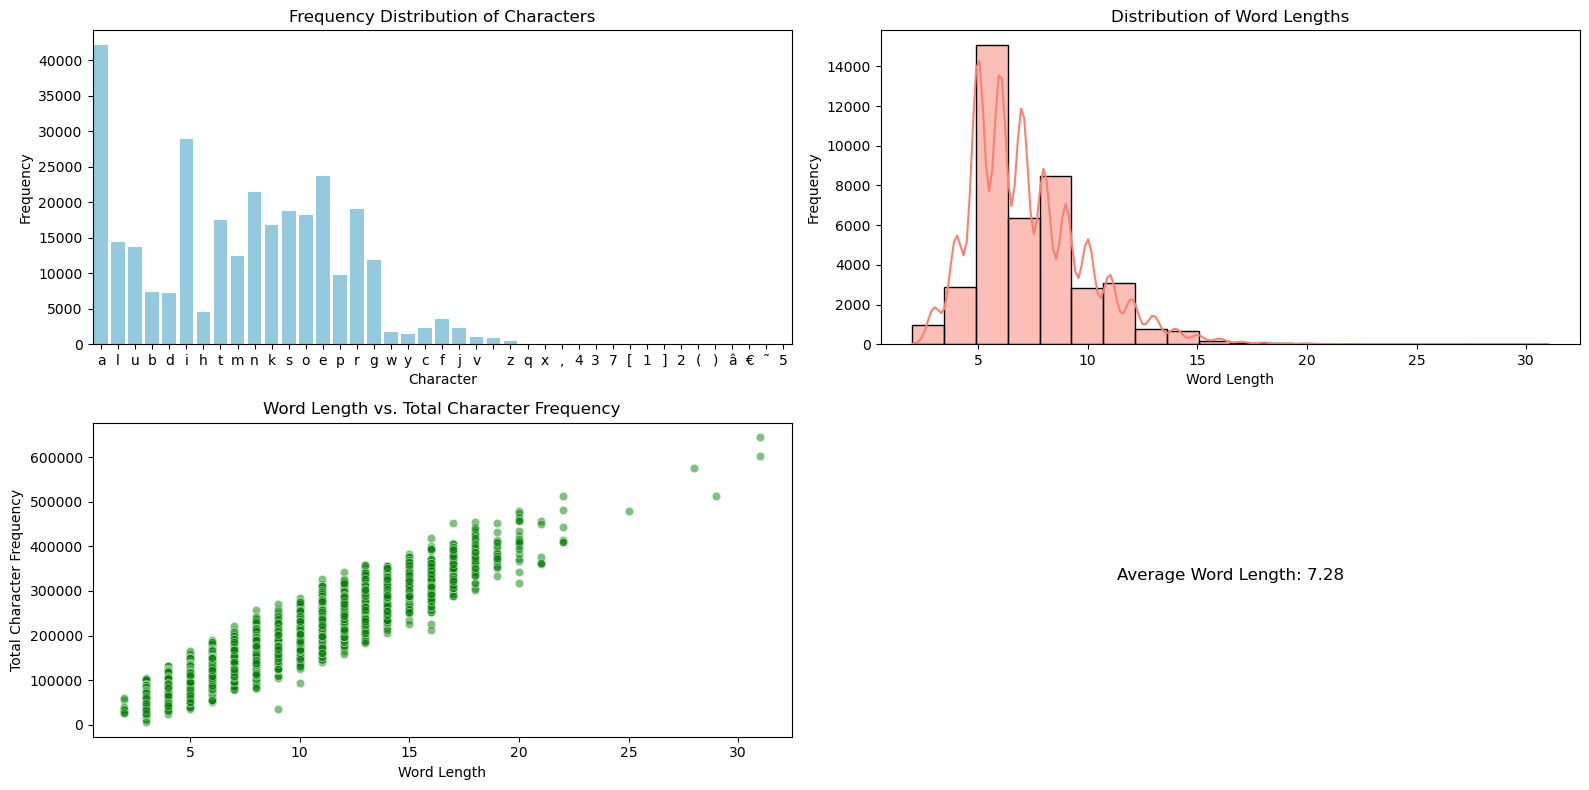

In [5]:
# Calculate the frequency distribution of individual characters
all_characters = [char for word in lines for char in word]
char_counts = Counter(all_characters)

# Calculate the distribution of word lengths
word_lengths = [len(word) for word in lines]

# Calculate the total character frequency for each word
word_char_frequencies = [sum(char_counts[char] for char in word) for word in lines]

# Calculate the average word length
avg_word_length = sum(word_lengths) / len(word_lengths)

# Plotting the insights
plt.figure(figsize=(16, 8))

# Plotting the frequency distribution of individual characters
plt.subplot(2, 2, 1)
sns.barplot(x=list(char_counts.keys()), y=list(char_counts.values()), color='skyblue')
plt.title('Frequency Distribution of Characters')
plt.xlabel('Character')
plt.ylabel('Frequency')

# Plotting the distribution of word lengths
plt.subplot(2, 2, 2)
sns.histplot(word_lengths, bins=20, kde=True, color='salmon')
plt.title('Distribution of Word Lengths')
plt.xlabel('Word Length')
plt.ylabel('Frequency')

# Plotting the relationship between word length and total character frequency
plt.subplot(2, 2, 3)
sns.scatterplot(x=word_lengths, y=word_char_frequencies, color='green', alpha=0.5)
plt.title('Word Length vs. Total Character Frequency')
plt.xlabel('Word Length')
plt.ylabel('Total Character Frequency')

# Calculating and displaying the average word length
plt.subplot(2, 2, 4)
plt.text(0.5, 0.5, f'Average Word Length: {avg_word_length:.2f}', fontsize=12, ha='center')
plt.axis('off')

plt.tight_layout()
plt.show()

### Preprocessing

In [6]:
# Define a function for preprocessing text
def process_sentence(sentence):
    """
    Preprocesses a sentence by converting it to lowercase, removing special characters,
    and replacing newline characters.

    Args:
    - sentence (str): The input sentence to be processed.

    Returns:
    - str: The processed sentence.
    """
    # Convert the sentence to lowercase
    processed_sentence = sentence.lower()
    
    # Remove special characters except for alphanumeric characters and spaces
    processed_sentence = re.sub(r'[^0-9a-zA-Z ]', '', processed_sentence)
    
    # Replace newline characters with an empty string
    processed_sentence = processed_sentence.replace('\n', '')
    
    return processed_sentence

In [7]:
# Process each line in the 'lines' list using the 'process_sentence' function
lines = [process_sentence(line) for line in lines]

# Initialize an empty list to store individual words
words = []

# Split each processed line into words and add them to the 'words' list
for line in lines:
    words += [word for word in line.split()]

# Remove duplicates by converting 'words' to a set and back to a list
lines = list(set(words))

# Display the first four unique words
print("\n".join(lines[:4]))

# Display the total number of unique words
print("Number of items:", len(lines))

episod
adat
renai
paraglosa
Number of items: 41059


In [8]:
# Define the character set including alphabets, numbers, and special characters
char_set = list(" abcdefghijklmnopqrstuvwxyz0123456789")
codes = ["\t", "\n", '#']

# Initialize the count variable to keep track of the total number of characters
count = len(char_set)

# Create a mapping from characters to integers and vice versa
char2int = {char_set[x]: x for x in range(len(char_set))}
int2char = {char2int[x]: x for x in char_set}

# Update the mappings for special characters
for i in range(len(codes)):
    code = codes[i]
    char2int[code] = count
    int2char[count] = code
    count += 1

# Print the mappings
print(char2int)
print(int2char)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '0': 27, '1': 28, '2': 29, '3': 30, '4': 31, '5': 32, '6': 33, '7': 34, '8': 35, '9': 36, '\t': 37, '\n': 38, '#': 39}
{0: ' ', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: '0', 28: '1', 29: '2', 30: '3', 31: '4', 32: '5', 33: '6', 34: '7', 35: '8', 36: '9', 37: '\t', 38: '\n', 39: '#'}


In [9]:
# Define the character set including alphabets, numbers, and special characters
char_set = list(" abcdefghijklmnopqrstuvwxyz0123456789")

def gen_gibberish(line, thresh=0.2):
    """
    Generates gibberish by randomly modifying characters in the input 'line'.

    Args:
    - line (str): The input line to generate gibberish from.
    - thresh (float): The threshold for generating gibberish (0 to 1).

    Returns:
    - str: The gibberish generated from the input line.
    """
    # Calculate the number of times to apply modifications based on the threshold
    times = int(random.randrange(1, len(line)) * thresh)

    while times != 0:
        # Randomly choose the type of modification to apply
        val = random.randrange(0, 10)

        # Delete or add a character
        if val <= 5:
            index = random.randrange(2, len(line))
            if val <= 5:
                # Delete character
                line = line[:index] + line[index+1:]
            else:
                # Add character
                insert_index = random.randrange(0, len(char_set))
                line = line[:index] + char_set[insert_index] + line[index:]
        else:
            # Replace a character
            index = random.randrange(0, len(char_set))
            replace_index = random.randrange(2, len(line))
            line = line[:replace_index] + char_set[index] + line[replace_index+1:]

        times -= 1

    return line

# Example usage
sample = "example"
gib = gen_gibberish(sample)
print("Original:", sample)
print("Gibberish:", gib)

Original: example
Gibberish: exampe


In [10]:
# Create empty lists to store input and target texts
input_texts = []
target_texts = []

# Repeat factor to generate multiple gibberish versions for each line
REPEAT_FACTOR = 1

# Percentage of lines to skip from the beginning of the 'lines' list
SKIP = int(len(lines) * 0.65)

# Iterate over lines starting from SKIP index
for line in lines[SKIP:]:
    # Check if the line has more than 10 characters
    if len(line) > 10:
        # Prepare the target text by adding a tab at the beginning and a newline at the end
        output_text = '\t' + line + '\n'

        # Generate gibberish versions of the input text and append to input_texts list
        for _ in range(REPEAT_FACTOR):
            input_text = gen_gibberish(line)
            input_texts.append(input_text)
            target_texts.append(output_text)

# Display the total number of samples generated
print("Number of samples:", len(input_texts))

Number of samples: 1482


In [11]:
# Calculate the maximum length of input and target texts
max_enc_len = max([len(x) for x in input_texts])
max_dec_len = max([len(x) for x in target_texts])

# Display the maximum lengths
print("Max Enc Len:", max_enc_len)
print("Max Dec Len:", max_dec_len)

Max Enc Len: 20
Max Dec Len: 24


In [12]:
import numpy as np

# Get the number of samples
num_samples = len(input_texts)

# Create zero vectors for encoder input data, decoder input data, and decoder target data
encoder_input_data = np.zeros((num_samples, max_enc_len, len(char_set)), dtype='float32')
decoder_input_data = np.zeros((num_samples, max_dec_len, len(char_set) + 2), dtype='float32')
decoder_target_data = np.zeros((num_samples, max_dec_len, len(char_set) + 2), dtype='float32')

# Display a message indicating that zero vectors have been created
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [13]:
# Fill in the encoder, decoder input, and decoder target data
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    # Fill in the encoder input data
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, char2int[char]] = 1

    # Fill in the decoder input data
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, char2int[char]] = 1

        # Fill in the decoder target data, excluding the first character
        if t > 0:
            decoder_target_data[i, t - 1, char2int[char]] = 1

# Display a message indicating completion
print("COMPLETED...")

COMPLETED...


### Build Model

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import numpy as np

# Define batch size, number of epochs, and latent dimension
batch_size = 128
epochs = 1000
latent_dim = 256

# Get the number of encoder and decoder tokens
num_enc_tokens = len(char_set)
num_dec_tokens = len(char_set) + 2  # includes \n and \t

# Define the encoder inputs
encoder_inputs = Input(shape=(None, num_enc_tokens))

# Define the encoder LSTM layer
encoder = LSTM(latent_dim, return_state=True)

# Get the encoder outputs and states
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Define the decoder inputs
decoder_inputs = Input(shape=(None, num_dec_tokens))

# Define the decoder LSTM layer
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Define the decoder output layer
decoder_dense = Dense(num_dec_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# Print a summary of the model
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 37)]           0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None, 39)]           0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 256),                301056    ['input_1[0][0]']             
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                            

In [15]:
# Train the model
history = model.fit(
    [encoder_input_data, decoder_input_data],  # Input data
    decoder_target_data,  # Target data
    epochs=epochs,  # Number of epochs
    batch_size=batch_size,  # Batch size
    validation_split=0.2  # Validation split
)

# Save the trained model
model.save('./RNNs2s.h5')

Epoch 1/1000

10/10 [==============================] - 8s 295ms/step - loss: 1.9698 - val_loss: 1.7004
Epoch 2/1000
10/10 [==============================] - 1s 142ms/step - loss: 1.6537 - val_loss: 1.6503
Epoch 3/1000
10/10 [==============================] - 1s 126ms/step - loss: 1.6088 - val_loss: 1.5581
Epoch 4/1000
10/10 [==============================] - 1s 126ms/step - loss: 1.5717 - val_loss: 1.5336
Epoch 5/1000
10/10 [==============================] - 1s 132ms/step - loss: 1.5716 - val_loss: 1.5323
Epoch 6/1000
10/10 [==============================] - 1s 148ms/step - loss: 1.5510 - val_loss: 1.5414
Epoch 7/1000
10/10 [==============================] - 1s 148ms/step - loss: 1.5483 - val_loss: 1.5255
Epoch 8/1000
10/10 [==============================] - 1s 150ms/step - loss: 1.5592 - val_loss: 1.5232
Epoch 9/1000
10/10 [==============================] - 1s 147ms/step - loss: 1.5373 - val_loss: 1.5222
Epoch 10/1000
10/10 [==============================] - 1s 144ms/step - loss: 1.54

### Testing & Evaluation

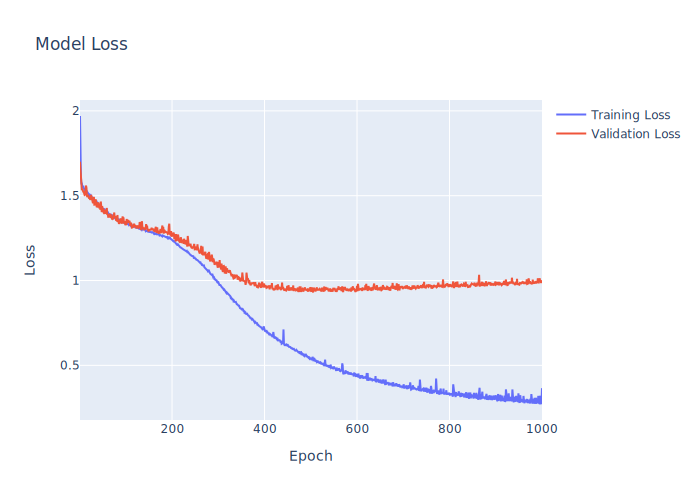

In [16]:
# Create traces
fig = go.Figure()

# Add training loss trace
fig.add_trace(go.Scatter(x=list(range(1, epochs+1)), y=history.history['loss'],
                    mode='lines',
                    name='Training Loss'))

# Add validation loss trace
fig.add_trace(go.Scatter(x=list(range(1, epochs+1)), y=history.history['val_loss'],
                    mode='lines',
                    name='Validation Loss'))

# Update layout
fig.update_layout(title='Model Loss',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')

# Show plot
fig.show()

In [38]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Define the number of samples to visualize
num_samples_to_visualize = 100

# Create a random sample of indices
sample_indices = np.random.choice(len(encoder_input_data), num_samples_to_visualize, replace=False)

# Create a grid layout for the subplots
fig = make_subplots(rows=10, cols=10, subplot_titles=[f'Sample {i+1}' for i in range(num_samples_to_visualize)])

# Loop over the samples
for idx, i in enumerate(sample_indices, start=1):
    # Get the input, target, and predicted sequences for the chosen sample
    input_seq = encoder_input_data[i : i + 1]
    target_seq = decoder_target_data[i : i + 1]
    pred_seq = preds[i]

    # Convert sequences to words
    def seq_to_text(seq, int2char):
        return ''.join([int2char[np.argmax(char)] for char in seq])

    input_text = seq_to_text(input_seq[0], int2char)
    target_text = seq_to_text(target_seq[0], int2char)
    pred_text = seq_to_text(pred_seq, int2char)

    # Find the maximum length among input, target, and predicted sequences
    max_len = max(input_seq.shape[1], target_seq.shape[1], pred_seq.shape[1])

    # Pad sequences to the maximum length
    def pad_sequence(seq, max_len):
        padded_seqs = []
        for s in seq:
            pad_width = max_len - s.shape[0]
            padded_seq = np.pad(s, (0, pad_width), mode='constant', constant_values=0)
            padded_seqs.append(padded_seq)
        return np.array(padded_seqs)

    input_seq_padded = pad_sequence(input_seq, max_len)
    target_seq_padded = pad_sequence(target_seq, max_len)
    pred_seq_padded = pad_sequence(pred_seq, max_len)

    # Add input, target, and predicted sequences as subplots
    fig.add_trace(go.Heatmap(z=input_seq_padded[0].T, colorscale='Viridis', name='Input'), row=(idx-1)//10+1, col=(idx-1)%10+1)
    fig.add_trace(go.Heatmap(z=target_seq_padded[0].T, colorscale='Viridis', name='Target'), row=(idx-1)//10+1, col=(idx-1)%10+1)
    fig.add_trace(go.Heatmap(z=pred_seq_padded[0].T, colorscale='Viridis', name='Predicted'), row=(idx-1)//10+1, col=(idx-1)%10+1)

    # Add text annotations for input, target, and predicted words along the x-axis
    fig.update_xaxes(title_text=f'Input: {input_text}<br>Target: {target_text}<br>Predicted: {pred_text}', row=(idx-1)//10+1, col=(idx-1)%10+1)

# Update layout
fig.update_layout(title_text="Input, Target, and Predicted Sequences Grid",
                  height=3200, width=2000)

# Show the plot
fig.show()